In [411]:
import tensorflow as tf
import numpy as np
import os
import pandas as pd
import datetime
import matplotlib.pyplot as plt
import logging

In [412]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Setze die Log-Ebene auf '2' für Warnungen und Fehler

tf.get_logger().setLevel(logging.ERROR)

In [422]:
#-----------HYPERPARAMETERS----------------#
SEQUENCE_LENGTH = [32,64,128]
HIDDEN_LENGTH = 128
N_FEATURES = 1

LEARNING_RATE = 1e-3
EPOCHS = 400
NUM_OF_LAYERS = 1

In [399]:
#-----------Loading the dataset----------------#

zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [400]:
df = pd.read_csv(csv_path)

In [401]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
p (mbar),420551.0,989.212776,8.358481,913.60,984.20,989.58,994.72,1015.35
T (degC),420551.0,9.450147,8.423365,-23.01,3.36,9.42,15.47,37.28
Tpot (K),420551.0,283.492743,8.504471,250.60,277.43,283.47,289.53,311.34
Tdew (degC),420551.0,4.955854,6.730674,-25.01,0.24,5.22,10.07,23.11
rh (%),420551.0,76.008259,16.476175,12.95,65.21,79.30,89.40,100.00
VPmax (mbar),420551.0,13.576251,7.739020,0.95,7.78,11.82,17.60,63.77
VPact (mbar),420551.0,9.533756,4.184164,0.79,6.21,8.86,12.35,28.32
VPdef (mbar),420551.0,4.042412,4.896851,0.00,0.87,2.19,5.30,46.01
sh (g/kg),420551.0,6.022408,2.656139,0.50,3.92,5.59,7.80,18.13
H2OC (mmol/mol),420551.0,9.640223,4.235395,0.80,6.29,8.96,12.49,28.82


In [402]:
data = df['T (degC)'].to_numpy()

In [403]:
def create_weather_dataset_for_one_timetep_prediction(data, n_samples, sequence_length, n_features = 1, validation = False):
    """
    Function to create a dataset for a prediction task to predict the next value after the input sequence
    
    :param data: 
    :return: 
    """
    
    sequences = []
    labels = []
    
    for _ in range (n_samples):
        index = np.random.randint(0, len(data) - sequence_length -1)
        x = data[index:index+sequence_length]
        x = np.expand_dims(x, axis=-1)
        sequences.append(x)
        y = data[index+sequence_length+1]
        y = np.expand_dims(y, axis=-1)
        labels.append(y)
        
    if not validation:
        return tf.data.Dataset.from_tensor_slices((sequences, labels)).shuffle(n_samples).batch(32).prefetch(tf.data.AUTOTUNE)
    else:
        return tf.data.Dataset.from_tensor_slices((sequences, labels)).shuffle(n_samples).batch(n_samples).prefetch(tf.data.AUTOTUNE)


In [404]:
def create_weather_dataset_for_multiple_timesteps_prediction(data, n_samples, sequence_length, n_features = 1, validation = False):
    """
    Function to create a dataset for a prediction task to predict the next value after the input sequence
    
    :param data: 
    :return: 
    """
    
    sequences = []
    labels = []
    
    for _ in range (n_samples):
        index = np.random.randint(0, len(data) - sequence_length - sequence_length)
        x = data[index:index+sequence_length]
        x = np.expand_dims(x, axis=-1)
        sequences.append(x)
        
        y = data[index+sequence_length:index+sequence_length+sequence_length]
        y = np.expand_dims(y, axis=-1)
        labels.append(y)
    if not validation:
        return tf.data.Dataset.from_tensor_slices((sequences, labels)).shuffle(n_samples).batch(32).prefetch(tf.data.AUTOTUNE)
    else:
        return tf.data.Dataset.from_tensor_slices((sequences, labels)).shuffle(n_samples).batch(n_samples).prefetch(tf.data.AUTOTUNE)

In [405]:
class LSTMCell(tf.keras.layers.AbstractRNNCell):
    """
    Custom LSTM cell implementation
    """
    
    def __init__(self, input_length, hidden_length):
        """
        Initializes the LSTM cell with input and hidden dimensions
        
        :param input_length: Length of the input vector
        :param hidden_length: Length of the hidden state vector
        """
        super(LSTMCell, self).__init__()
        self.input_length = input_length
        self.hidden_length = hidden_length

        # forget gate components
        self.linear_forget_w1 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_forget_r1 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # input gate components
        self.linear_gate_w2 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r2 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # cell memory components
        self.linear_gate_w3 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r3 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        # out gate components
        self.linear_gate_w4 = tf.keras.layers.Dense(self.hidden_length, use_bias=True)
        self.linear_gate_r4 = tf.keras.layers.Dense(self.hidden_length, use_bias=False)

        self.sigmoid = tf.keras.layers.Activation('sigmoid')
        self.tanh = tf.keras.layers.Activation('tanh')

    @property
    def state_size(self):
        """
        Returns the size of the LSTM cell state
        """
        return self.hidden_length, self.hidden_length
    
    @tf.function
    def call(self, inputs, states):
        """
        Performs the forward pass through the LSTM cell
        
        :param inputs: Input tensor
        :param states: Tuple containing the previous hidden state and cell state
        """
        
        h, c = states

        # forget gate
        f = self.sigmoid(self.linear_forget_w1(inputs) + self.linear_forget_r1(h))

        # input gate
        i = self.sigmoid(self.linear_gate_w2(inputs) + self.linear_gate_r2(h))

        # cell memory
        g = self.tanh(self.linear_gate_w3(inputs) + self.linear_gate_r3(h))
        c_next = f * c + i * g

        # output gate
        o = self.sigmoid(self.linear_gate_w4(inputs) + self.linear_gate_r4(h))

        # next hidden state
        h_next = o * self.tanh(c_next)

        return h_next, [h_next, c_next]


In [417]:
class RNNModel(tf.keras.Model):
    def __init__(self, sequence_length, hidden_length, cumsum):
        super().__init__()
        
        self.cumsum = cumsum
        
        self.cell = LSTMCell(input_length=sequence_length, hidden_length=hidden_length)
        
        self.rnn_layer = tf.keras.layers.RNN(self.cell, return_sequences=self.cumsum, unroll=True)
        
        
        if cumsum:
            self.output_layer = tf.keras.layers.Dense(sequence_length)
        else:
            self.output_layer = tf.keras.layers.Dense(1)

        self.metrics_list = [tf.keras.metrics.Mean(name="loss")]

    @property
    def metrics(self):
        return self.metrics_list

    def reset_metrics(self):
        for metric in self.metrics:
            metric.reset_state()
    
    @tf.function
    def call(self, sequence, training=False):
        x = self.rnn_layer(sequence)
        x = self.output_layer(x)
        return x

    
    @tf.function
    def train_step(self, data):
        """
        Standard train_step method
        :param data: 
        :return: 
        """

        sequence, label = data
        with tf.GradientTape() as tape:
            output = self.call(sequence, training=True)
            loss = self.compiled_loss(label, output, regularization_losses=self.losses)
        gradients = tape.gradient(loss, self.trainable_variables)

        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

    @tf.function
    def test_step(self, data):
        """
        Standard test_step method
        :param data: 
        :return: 
        """

        sequence, label = data
        output = self.call(sequence, training=False)
        loss = self.compiled_loss(label, output, regularization_losses=self.losses)

        self.metrics[0].update_state(loss)

        return {m.name : m.result() for m in self.metrics}

In [420]:
def plot_predictions(input_sequence, expected_output, actual_output):
    plt.figure(figsize=(10, 6))
    plt.plot(input_sequence, label='Input Sequence', marker='o')
    plt.plot(range(len(input_sequence), len(input_sequence) + len(expected_output)),
             expected_output, label='Expected Output', marker='o')
    plt.plot(range(len(input_sequence), len(input_sequence) + len(actual_output)),
             actual_output[0], label='Actual Output', marker='o')
    plt.xlabel('Time Steps')
    plt.ylabel('Value')
    plt.title('Input Sequence, Expected Output, and Actual Output')
    plt.legend()
    plt.grid(True)
    
    # Festlegen der Achsengröße
    plt.xlim(0, len(input_sequence) + len(expected_output))
    plt.ylim(-20, 30)  # Beispiel: Festlegen der y-Achsen-Grenzen auf 0 und 100
    
    plt.show()

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 32, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 32, 1), dtype=tf.float64, name=None))>


2024-03-28 12:35:37.953167: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1024,32,1]
	 [[{{node Placeholder/_0}}]]
2024-03-28 12:35:37.953909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1024,32,1]
	 [[{{node Placeholder/_1}}]]
2024-03-28 12:35:38.125500: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype double and shape [?,32

Train Losses: [137.0511474609375, 76.0967788696289, 43.503482818603516, 30.20496368408203, 24.388887405395508, 21.27267074584961, 19.64307975769043, 18.624177932739258, 17.8773193359375, 17.295101165771484, 16.85114288330078, 16.46080780029297, 16.04507064819336, 15.760891914367676, 15.734198570251465, 15.32357406616211, 15.087066650390625, 14.965678215026855, 14.929636001586914, 14.777925491333008, 14.632499694824219, 14.21336841583252, 14.20549488067627, 14.18207836151123, 13.803831100463867, 13.86520004272461, 13.747957229614258, 13.599180221557617, 13.567582130432129, 13.62010383605957, 13.543482780456543, 13.473079681396484, 13.256147384643555, 13.202917098999023, 12.9860258102417, 12.968018531799316, 13.371652603149414, 13.063581466674805, 12.895459175109863, 13.073686599731445, 12.788723945617676, 12.9370698928833, 12.690937042236328, 12.75886058807373, 12.706233978271484, 12.566710472106934, 12.346966743469238, 12.387287139892578, 12.32181167602539, 12.503959655761719, 12.34980

2024-03-28 12:37:49.280644: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [512,32,1]
	 [[{{node Placeholder/_1}}]]
2024-03-28 12:37:49.280925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [512,32,1]
	 [[{{node Placeholder/_1}}]]


16/16 [==============================] - 0s 2ms/step


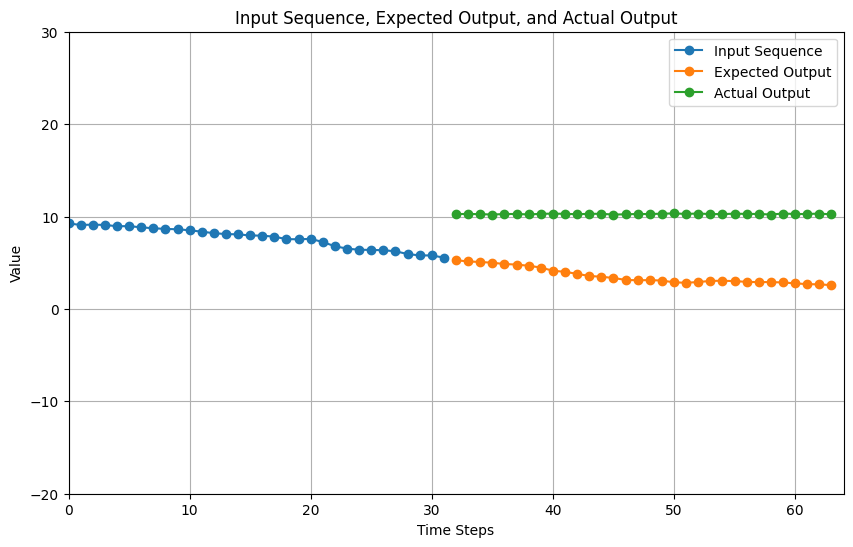

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 64, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 64, 1), dtype=tf.float64, name=None))>


2024-03-28 12:37:49.868091: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1024,64,1]
	 [[{{node Placeholder/_0}}]]
2024-03-28 12:37:49.868202: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1024,64,1]
	 [[{{node Placeholder/_1}}]]
2024-03-28 12:37:50.039909: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype double and shape [?,64

Train Losses: [140.31512451171875, 79.51750183105469, 46.108699798583984, 34.84314727783203, 30.719619750976562, 28.62507438659668, 27.612140655517578, 27.101318359375, 26.43465232849121, 26.095985412597656, 25.64750099182129, 25.307924270629883, 25.25313949584961, 25.188840866088867, 24.997346878051758, 24.722211837768555, 24.39151954650879, 24.446226119995117, 23.9566650390625, 24.14764976501465, 23.7603702545166, 23.83359146118164, 23.454742431640625, 23.7077693939209, 23.100027084350586, 23.369112014770508, 22.44994354248047, 22.607385635375977, 22.236480712890625, 22.378814697265625, 21.75380516052246, 21.331165313720703, 22.146228790283203, 22.322307586669922, 21.532276153564453, 21.802162170410156, 21.331501007080078, 21.414188385009766, 20.88862419128418, 20.821807861328125, 20.936450958251953, 20.963848114013672, 21.03190040588379, 20.956283569335938, 20.58922576904297, 20.45653533935547, 20.761411666870117, 20.611602783203125, 20.076597213745117, 20.54167366027832, 20.1661682

2024-03-28 12:42:02.470841: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [512,64,1]
	 [[{{node Placeholder/_0}}]]
2024-03-28 12:42:02.470960: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [512,64,1]
	 [[{{node Placeholder/_1}}]]


16/16 [==============================] - 0s 4ms/step


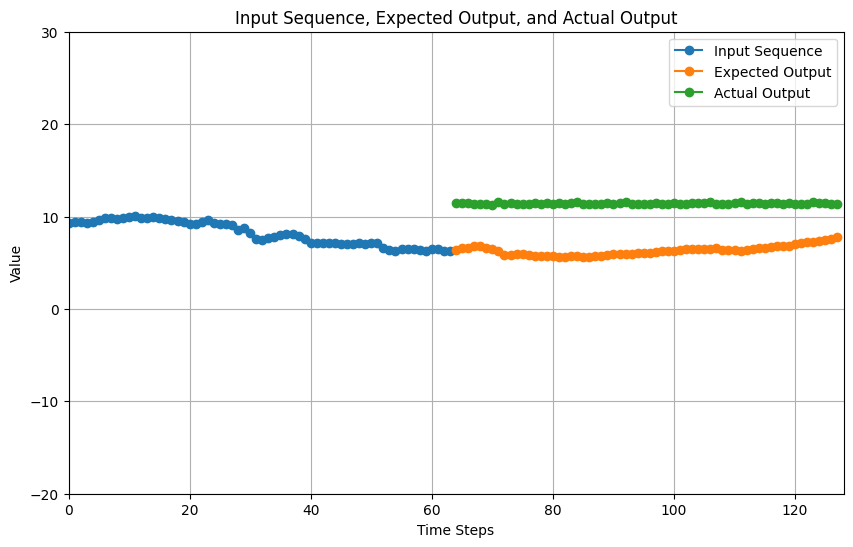

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 128, 1), dtype=tf.float64, name=None), TensorSpec(shape=(None, 128, 1), dtype=tf.float64, name=None))>


2024-03-28 12:42:03.239578: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype double and shape [1024,128,1]
	 [[{{node Placeholder/_0}}]]
2024-03-28 12:42:03.239689: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_1' with dtype double and shape [1024,128,1]
	 [[{{node Placeholder/_1}}]]
2024-03-28 12:42:03.571171: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'data' with dtype double and shape [?,

KeyboardInterrupt: 

In [423]:
#-----------Loop for different sequence lengths with compile and fit----------------#

for length in SEQUENCE_LENGTH:
    train_dataset = create_weather_dataset_for_multiple_timesteps_prediction(data, 1024,length, 1,False)
    val_dataset = create_weather_dataset_for_multiple_timesteps_prediction(data, 512, length,1, True)
    print(train_dataset)
    
    model = RNNModel(sequence_length=length, hidden_length=HIDDEN_LENGTH, cumsum=True)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.MeanSquaredError()

    # compile the model
    model.compile(optimizer = optimizer, loss=loss)
    
    EXPERIMENT_NAME = "LSTM_COMPILE"
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{length}")
    
    history = model.fit(train_dataset, 
                        validation_data=val_dataset,
                        epochs=EPOCHS,
                        callbacks=[logging_callback],
                        verbose=0)
    
    # Extrahiere die Trainings- und Validierungsverluste aus dem History-Objekt
    train_losses = history.history['loss']
    val_losses = history.history['val_loss']
    
    print("Train Losses:", train_losses)
    print("Validation Losses:", val_losses)
    
    # Testen des Modells
    for test_input, test_output in val_dataset.take(1):
        predicted_output = model.predict(test_input)
        
        # Plotten der Ergebnisse
        input_sequence = test_input[0].numpy().squeeze()  # erste Sequenz im Batch
        expected_output = test_output[0].numpy().squeeze()  # erwartete Ausgabe für die erste Sequenz im Batch
        actual_output = predicted_output[0].squeeze()  # vorhergesagte Ausgabe für die erste Sequenz im Batch
        plot_predictions(input_sequence, expected_output, actual_output)

In [200]:
#%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [203]:
#%tensorboard --logdir="logs/LSTM_SUM_PREDICTION" --port=6009

Reusing TensorBoard on port 6009 (pid 10708), started 0:09:43 ago. (Use '!kill 10708' to kill it.)

In [57]:
# %tensorboard --logdir="logs/LSTM_CUMSUM_prediction" --port=6004

In [ ]:
'''

#-----------Loop for different sequence lengths with compile and fit----------------#

for length in SEQUENCE_LENGTH:
    train_dataset = create_dataset_for_cum_sum_prediction(1024, length, 1, False)
    val_dataset = create_dataset_for_cum_sum_prediction(512, length, 1, True)
    
    model = RNNModel(num_layers=NUM_OF_LAYERS, sequence_length=length, hidden_length=HIDDEN_LENGTH, cumsum=True)
    optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=LEARNING_RATE)
    loss = tf.keras.losses.MeanAbsoluteError()

    # compile the model
    model.compile(optimizer = optimizer, loss=loss)
    
    EXPERIMENT_NAME = "LSTM_sum_prediction"
    current_time = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
    logging_callback = tf.keras.callbacks.TensorBoard(log_dir=f"./logs/{EXPERIMENT_NAME}/{length}")
    
    history = model.fit(train_dataset, 
                        validation_data=val_dataset,
                        epochs=EPOCHS,
                        callbacks=[logging_callback],
                        verbose=0)

'''

In [ ]:
'''

def create_dataset_for_sum_prediction(n_samples, sequence_length, n_features, validation):
    """
    Function to create a dataset for the sum prediction task. The function generates random integers between 0 and 10 and calculates the sum of the sequence
    :param n_samples:  number of samples in the dataset
    :param sequence_length: length of the sequence
    :param n_features: number of features in the sequence
    :return: a tf.data.Dataset object containing the input and output pairs
    """
    x = tf.cast(np.random.randint(low=0, high=11, size=(n_samples, sequence_length, n_features)), tf.float32)
    sums = []
    for sample in range(n_samples):
        value = x[sample, :, :]
        sums.append(tf.reduce_sum(value))
    y = tf.cast(tf.expand_dims(tf.convert_to_tensor(sums), axis=1), tf.float32)
    if not validation:
        return tf.data.Dataset.from_tensor_slices((x, y)).shuffle(n_samples).batch(32).prefetch(tf.data.AUTOTUNE)
    else:
        return tf.data.Dataset.from_tensor_slices((x, y)).batch(512).prefetch(tf.data.AUTOTUNE)


'''


In [ ]:
'''

def create_dataset_for_cum_sum_prediction(n_samples, sequence_length, n_features, validation):
    """
    Function to create a dataset for the cumulative sum prediction task. The function generates random integers between 0 and 10 and calculates the cumulative sum of the sequence
    :param n_samples: number of samples in the dataset
    :param sequence_length: length of the sequence
    :param n_features: number of features in the sequence
    :return: a tf.data.Dataset object containing the input and output pairs
    """
    x = tf.cast(np.random.randint(low=0, high=11, size=(n_samples, sequence_length, n_features)), tf.float32)
    sums = []
    for sample in range(n_samples):
        value = x[sample, :, :]
        sums.append(tf.cumsum(value, axis=0))
    y = tf.cast(tf.convert_to_tensor(sums), tf.float32)
    if not validation:
        return tf.data.Dataset.from_tensor_slices((x, y)).batch(32).prefetch(tf.data.AUTOTUNE)
    else:
        return tf.data.Dataset.from_tensor_slices((x, y)).shuffle(n_samples).batch(512).prefetch(tf.data.AUTOTUNE)
'''

In [ ]:
'''

#-----------CUMSUM PREDICTION FOR DIFFERENT SEQUENCE LENGTH----------------#


config_name= "LSTM_CUMSUM_prediction"

for length in SEQUENCE_LENGTH:
    train_dataset = create_dataset_for_cum_sum_prediction(1024, length, 1, False)
    val_dataset = create_dataset_for_cum_sum_prediction(512, length, 1, True)
    
    train_log_path = f"logs/{config_name}/{length}/train"
    test_log_path = f"logs/{config_name}/{length}/val"
    
    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)
    
    # log writer for validation metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)
    
    model = RNNModel(num_layers=NUM_OF_LAYERS, sequence_length=length, hidden_length=HIDDEN_LENGTH, cumsum=True)
   
    train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train_dataset, val_dataset, train_summary_writer, test_summary_writer)

'''

In [ ]:
'''

#----------Training------------#

import tqdm

def training_loop(model, train, test, train_summary_writer, test_summary_writer):
    # Lists to store training and validation metrics across epochs
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    # Loop through epochs
    for epoch in range(EPOCHS):

        # Training
        for data in tqdm.tqdm(train, position=0, leave=False, desc=f"Epoch {epoch}"):
            # Perform a training step using the model
            metrics = model.train_step(data)

            # Log training metrics to TensorBoard
            with train_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # Store training metrics for the epoch
        train_loss.append(metrics["loss"].numpy())

        # Print and reset training metrics
        if epoch % 40 == 0:
            print(f"EPOCH {epoch}")
            print([f"{key}: {value.numpy()}" for (key, value) in metrics.items()])
        model.reset_metrics()

        # Testing
        for data in test:
            # Perform a testing step using the model
            metrics = model.test_step(data)

            # Log validation metrics to TensorBoard
            with test_summary_writer.as_default():
                for metric in model.metrics:
                    tf.summary.scalar(f"{metric.name}", metric.result(), step=epoch)

        # Store validation metrics for the epoch
        val_loss.append(metrics["loss"].numpy())

        # Print validation metrics
        if epoch % 40 == 0:
            print([f"val_{key}: {value.numpy()}" for (key, value) in metrics.items()])

        # Reset validation metrics
        model.reset_metrics()

    # Return lists of training and validation metrics for analysis or plotting
    return train_loss, train_acc, val_loss, val_acc

'''

In [ ]:
'''

#-----------SUM PREDICTION FOR DIFFERENT SEQUENCE LENGTH----------------#

config_name= "LSTM_TRAINING_LOOP"

for length in SEQUENCE_LENGTH:
    train_dataset = create_weather_dataset_for_multiple_timesteps_prediction(data, 1024, length, 1,False)
    print(train_dataset)
    val_dataset = create_weather_dataset_for_multiple_timesteps_prediction(data, 512, length,1, True)
    
    
    train_log_path = f"logs/{config_name}/{length}/train"
    test_log_path = f"logs/{config_name}/{length}/val"
    
    # log writer for training metrics
    train_summary_writer = tf.summary.create_file_writer(train_log_path)
    
    # log writer for validation metrics
    test_summary_writer = tf.summary.create_file_writer(test_log_path)
    
    model = RNNModel(sequence_length=length, hidden_length=HIDDEN_LENGTH, cumsum=True)
    train_losses, train_accuracies, val_losses, val_accuracies = training_loop(model, train_dataset, val_dataset, train_summary_writer, test_summary_writer)

'''